In [ ]:
#Profile lines to compare the elevation using DEM with bathymetry (Blue) and without bathymetry correction (yellow).

In [ ]:

import os
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import zipfile

# === INPUT PATHS ===
lines_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp"
dem_bathy_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\DEM_Bathy7.tif"
terrain_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Terrain.MD_DEMVoidFIll.tif"
output_dir = "cross_section_profiles"

# === LOAD DATA ===
lines_gdf = gpd.read_file(lines_path)
dem_bathy = rasterio.open(dem_bathy_path)
terrain_dem = rasterio.open(terrain_path)

# === FUNCTION: Sample Points Along Line ===
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num=num_points)
    return [line.interpolate(d) for d in distances]

# === CREATE OUTPUT FOLDER ===
os.makedirs(output_dir, exist_ok=True)

# === LOOP OVER EACH LINE ===
for idx, row in lines_gdf.iterrows():
    line = row.geometry
    points = interpolate_line(line, num_points=100)
    coords = [(pt.x, pt.y) for pt in points]

    # Sample elevation from both DEMs
    elev_bathy = [val[0] for val in dem_bathy.sample(coords)]
    elev_terrain = [val[0] for val in terrain_dem.sample(coords)]

    # Plot comparison
    plt.figure(figsize=(8, 4))
    plt.plot(elev_bathy, label='DEM_Bathy7', color='blue')
    plt.plot(elev_terrain, label='Terrain.MD_DEMVoidFIll', color='orange')
    plt.title(f"Cross Section {idx + 1}")
    plt.xlabel("Sample Point")
    plt.ylabel("Elevation (ft)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save figure
    plot_path = os.path.join(output_dir, f"CrossSection_{idx + 1}.png")
    plt.savefig(plot_path)
    plt.close()

print(f"✅ All profiles saved to: {output_dir}")


✅ All profiles saved to: cross_section_profiles


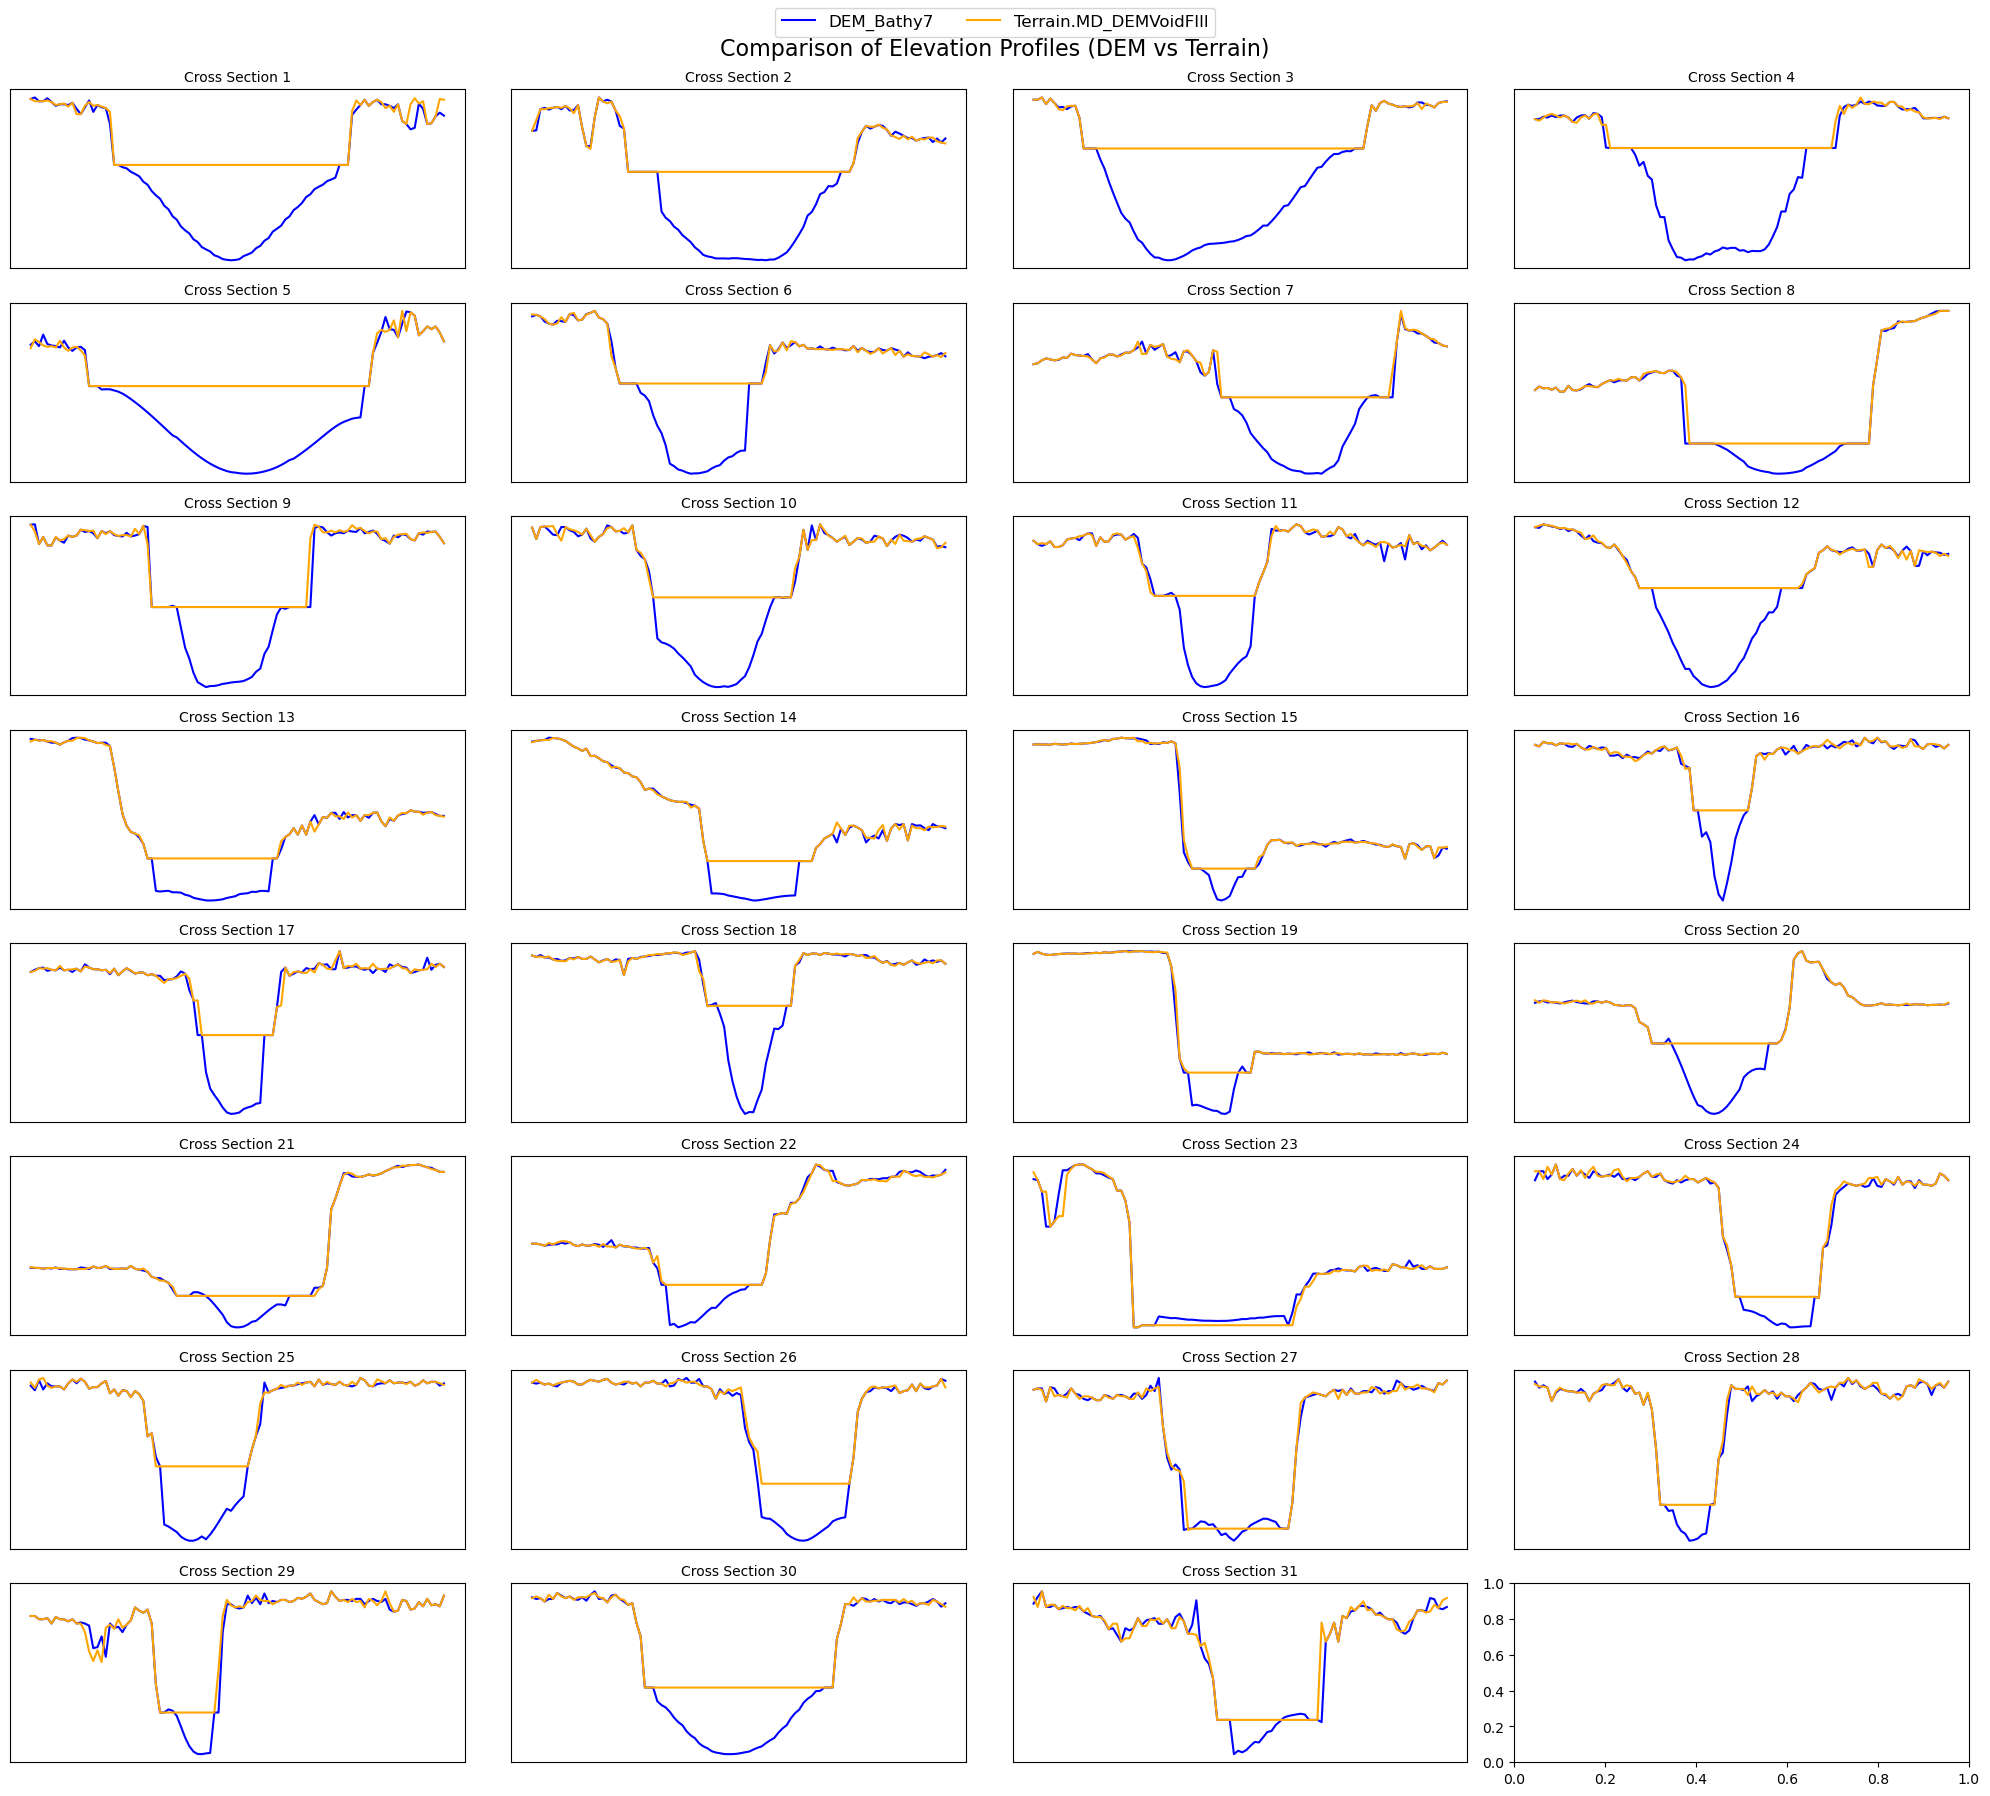

In [4]:
import os
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# === INPUT PATHS ===
lines_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp"
dem_bathy_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\DEM_Bathy7.tif"
terrain_path = r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Terrain.MD_DEMVoidFIll.tif"

# === LOAD DATA ===
lines_gdf = gpd.read_file(lines_path)
dem_bathy = rasterio.open(dem_bathy_path)
terrain_dem = rasterio.open(terrain_path)

# === FUNCTION: Sample Points Along Line ===
def interpolate_line(line, num_points=100):
    distances = np.linspace(0, line.length, num=num_points)
    return [line.interpolate(d) for d in distances]

# === SET UP GRID PLOT ===
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 18))
axes = axes.flatten()

# === LOOP OVER EACH LINE ===
for idx, row in lines_gdf.iterrows():
    if idx >= len(axes):
        break  # Just in case there are more than 32 lines

    ax = axes[idx]
    line = row.geometry
    points = interpolate_line(line, num_points=100)
    coords = [(pt.x, pt.y) for pt in points]

    # Sample elevation from both DEMs
    elev_bathy = [val[0] for val in dem_bathy.sample(coords)]
    elev_terrain = [val[0] for val in terrain_dem.sample(coords)]

    # Plot comparison
    ax.plot(elev_bathy, label='DEM_Bathy7', color='blue')
    ax.plot(elev_terrain, label='Terrain.MD_DEMVoidFIll', color='orange')
    ax.set_title(f"Cross Section {idx + 1}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True)

# === FORMAT LEGEND & LAYOUT ===
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize='large')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Comparison of Elevation Profiles (DEM vs Terrain)", fontsize=16)
plt.show()


c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in cast
  A_scaled /= ((a_max - a_min) / frac)
c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplotlib\image.py:500: RuntimeWarning: overflow encountered in cast
  vrange /= ((a_max - a_min) / frac)
c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplotlib\image.py:513: RuntimeWarning: overflow encountered in cast
  A_resampled *= ((a_max - a_min) / frac)
c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplotlib\image.py:513: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplotlib\image.py:514: RuntimeWarning: overflow encountered in cast
  vrange *= ((a_max - a_min) / frac)
c:\Users\dveronez\AppData\Local\anaconda3\envs\climate\Lib\site-packages\matplo

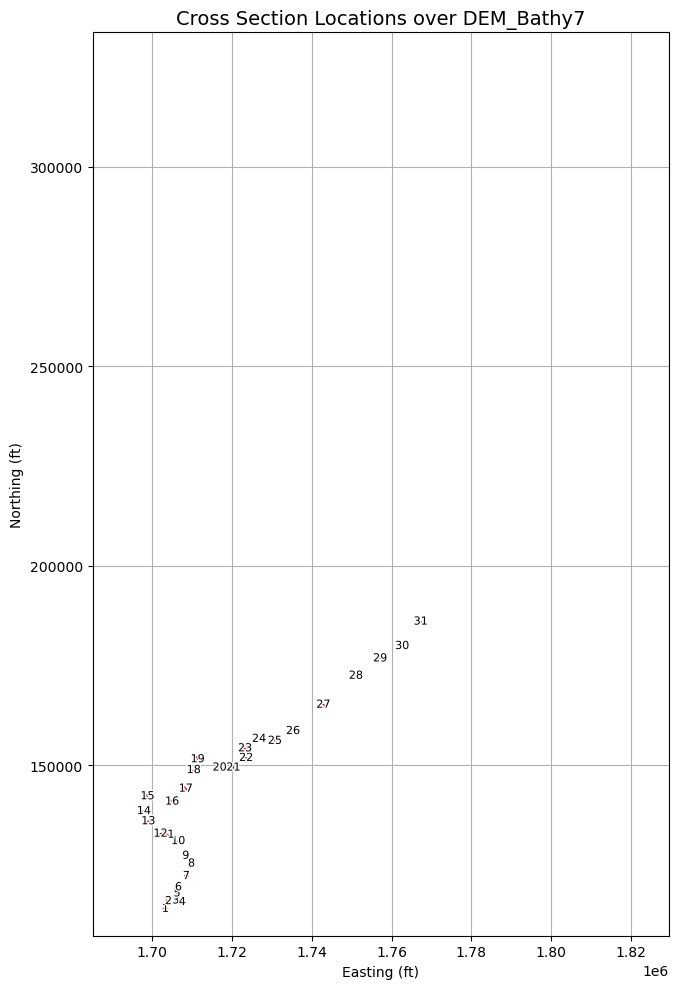

In [5]:
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.patheffects as pe

# === Plot DEM and cross sections ===
fig, ax = plt.subplots(figsize=(12, 10))

# Show DEM background in grayscale
show((dem_bathy, 1), ax=ax, cmap='gray', alpha=0.6)

# Plot all cross-section lines
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Add labels (optional: use centroid of each line)
for idx, row in lines_gdf.iterrows():
    line = row.geometry
    x, y = line.centroid.x, line.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Format
ax.set_title("Cross Section Locations over DEM_Bathy7", fontsize=14)
ax.set_xlabel("Easting (ft)")
ax.set_ylabel("Northing (ft)")
plt.grid(True)
plt.tight_layout()
plt.show()


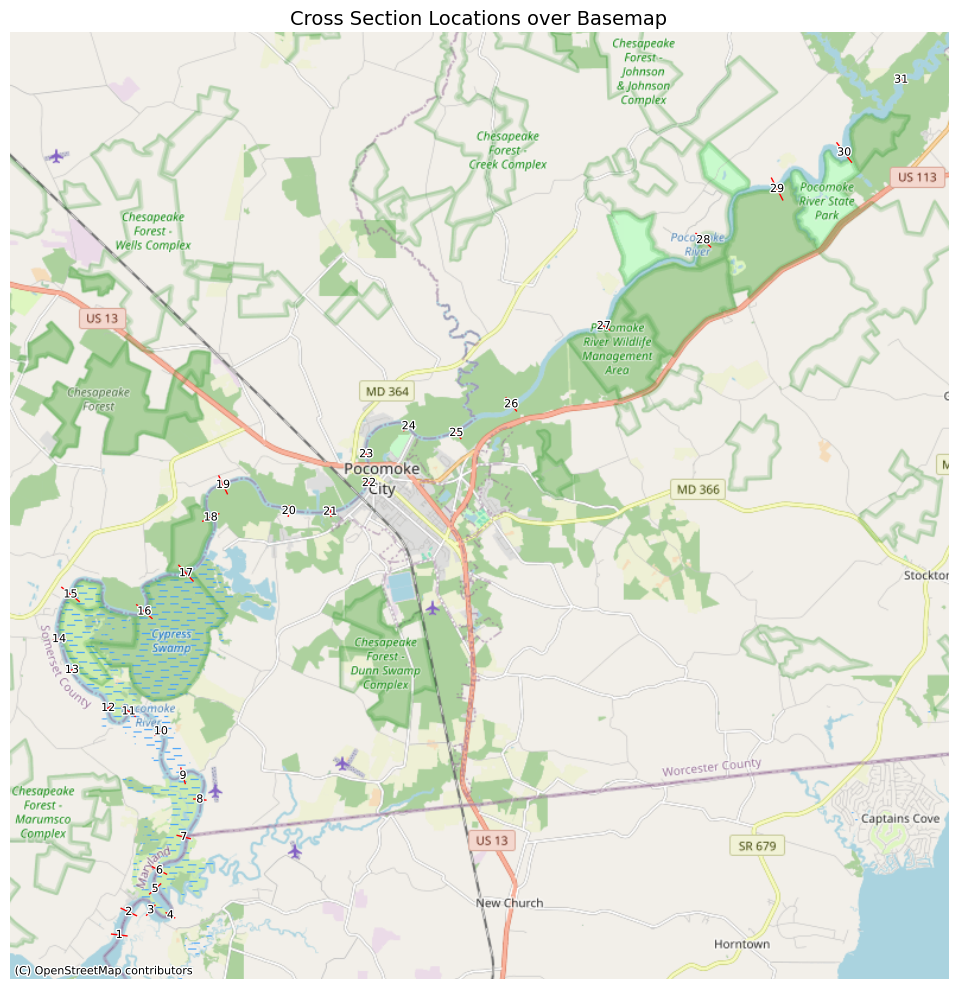

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.patheffects as pe

# === Load your shapefile ===
lines_gdf = gpd.read_file(r"C:\Github\Lab_work\Pocomoke\POCOMOKE_DEM\Cross.shp")

# === Convert to Web Mercator (required for basemap tiles) ===
lines_gdf = lines_gdf.to_crs(epsg=3857)

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 10))
lines_gdf.plot(ax=ax, edgecolor='red', linewidth=1)

# Label each cross-section
for idx, row in lines_gdf.iterrows():
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x, y, str(idx + 1), fontsize=8, ha='center', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])

# Add basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Format
ax.set_title("Cross Section Locations over Basemap", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()
